# Art Generation



N'est il pas formidable de pouvoir créer des filtres à partir de peintures célébres (ou pas) et de les appliquer à nos photos ? 
C'est le but de ce projet, j'ai décidé de prendre une peinture ressemblant au style du célèbre Pablo Picasso et de faire en sorte que ce style soit transmit dans une photo de mon album. 

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import scipy.io
import imageio
import scipy.misc
from scipy import io
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline
import h5py
from PIL import Image

In [ ]:
content_image = np.asarray(Image.open("/content/drive/MyDrive/IMG_4266.jpg"))
style_image = np.asarray(Image.open("/content/drive/MyDrive/picasso.jpg"))
# plt.figure(figsize=(10,10))
# plt.imshow(content_image);

Voici la photo sur laquelle je souhaite appliquer mon filtre:

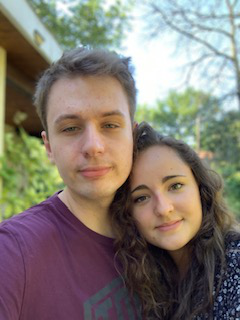

In [ ]:
ma_photo = Image.open('/content/drive/MyDrive/IMG_4266.jpg') 
ma_photo

Et voici la peinture :

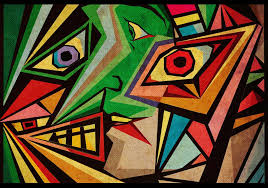

In [ ]:
peinture=Image.open('/content/drive/MyDrive/picasso.jpg')
peinture

Afin que le résultat soit optimal, j'ai choisi de prendre un modèle déjà entrainé, disponible sur [Kaggle](https://www.kaggle.com/teksab/imagenetvggverydeep19mat).

Quelques explications sur le modèle VGG:

C'est un modèle de réseau de neuronnes connu et performant, contenant 19 couches de convolutions pour le VGG-19 et 16 couches pour le VGG-16. Le modèle a atteint un score de 92,7% sur Imagenet, pour classifier en 1000 classes des objets de la vie courante.
L'architecture du modèle est la suivante :  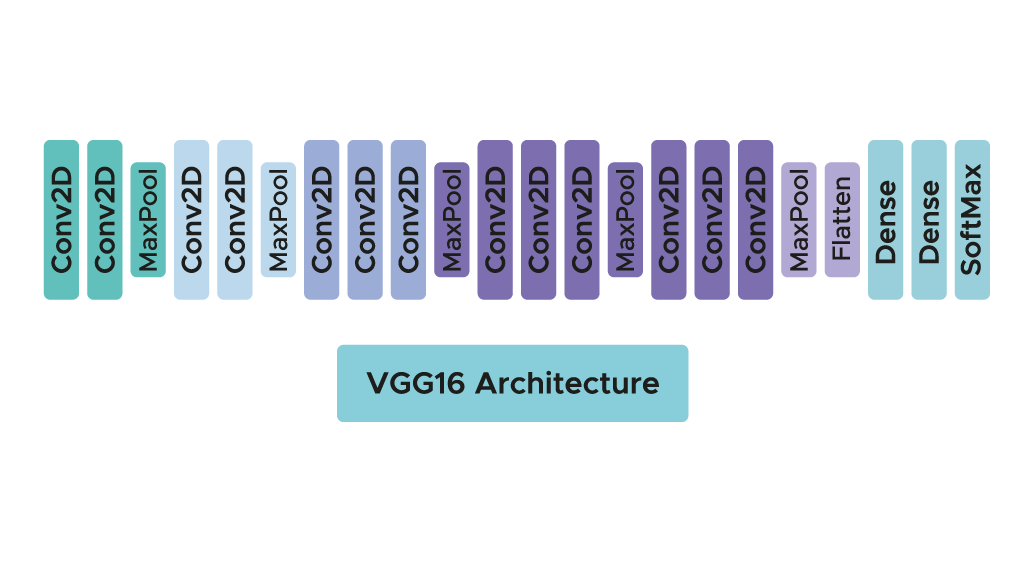  


Parmi les couches de convolution, on a des MaxPool qui permettent de réduire la taille des filtres, ainsi que Flatten qui permet "d'aplatir" la photo. La fonction d'activation SoftMax a été choisie car le but du modèle VGG est de prédire plusieurs classes.

In [ ]:
#Définition de paramétres de départ
largeur = 1000
hauteur = 1200
couleur = 3
taux_bruit = 0.5
moyenne = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [ ]:
def load_vgg_model(path):
    vgg = io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W, b
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    def _conv2d(prev_layer, layer, layer_name):    
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #construction architecture
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, hauteur, largeur, couleur)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("/content/drive/MyDrive/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

In [ ]:
def compute_content_cost(a_C,a_G):
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    #fonction de cout
    j_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return j_content

In [ ]:
def compute_style_cost_layer(a_S,a_G):
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
    
    S = tf.matmul(a_S,tf.transpose(a_S))#multiplie a_s*a_s produit matriciel
    G = tf.matmul(a_G,tf.transpose(a_G))
    
    j_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(S,G)))))
    
    return j_style_layer

In [ ]:
style_layers = [('conv1_2',0.3),
               ('conv3_2',0.3),
               ('conv3_3',0.3),
               ('conv4_2',0.3),
               ('conv5_1',0.3)]

In [ ]:
def compute_style_cost(model, style_layers):
    j_style=0
    
    for layer_name,coeff in style_layers:
        out = model[layer_name]
        
        a_S = sess.run(out)
        
        a_G = model[layer_name]
        
        j_style_layer = compute_style_cost_layer(a_S,a_G)
        j_style += coeff*j_style_layer
        
    return j_style

In [ ]:
def total_cost(j_content, j_style, alpha=10, beta=40):
    
    j = (alpha*j_content) + (beta*j_style)
    
    return j 

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

In [ ]:
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - moyenne
    return image

In [ ]:
content_image = Image.open("/content/drive/MyDrive/IMG_4266.jpg").resize((1000,1200))
content_image = np.array(content_image)

In [ ]:
style_image = Image.open("/content/drive/MyDrive/picasso.jpg").resize((1000,1200))
style_image = np.array(style_image)

In [ ]:
def generate_noisy_image(content_image, noise= taux_bruit):
    
    noisy_image  = np.random.uniform(-20,20,(1,hauteur, largeur, couleur)).astype('float32')
    input_image = (noisy_image * noise) + (content_image * (1-noise))
    
    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


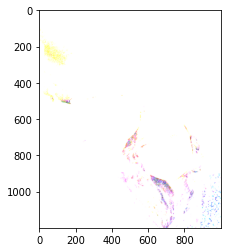

In [ ]:
generated_image = generate_noisy_image(content_image)
plt.imshow(generated_image[0])

In [ ]:
content_image=content_image.reshape(1,1200,1000,3)

In [ ]:
style_image=style_image.reshape(1,1200,1000,3)

In [ ]:
model = load_vgg_model("/content/drive/MyDrive/imagenet-vgg-verydeep-19.mat")

In [ ]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']
a_C = sess.run(out)
a_G = out

j_content = compute_content_cost(a_C, a_G)

In [ ]:
sess.run(model['input'].assign(style_image))
j_style = compute_style_cost(model, style_layers)

In [ ]:
j = total_cost(j_content,j_style,alpha=10,beta=40)

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.3)#adam optimizer mieux que RMSprop ou Momentum Adame = mélange des deux.
train_set = optimizer.minimize(j)

In [ ]:
def save_image(path, image):  
    image = image + moyenne
    
    # sauve image
    image = np.clip(image[0], 0,255).astype('uint8')
    imageio.imsave(path, image)

In [ ]:
def model_nn(sess, input_image, num_iterations = 10000):
    sess.run(tf.compat.v1.global_variables_initializer())
    # run l'image avec le bruit
    generated_image = sess.run(model["input"].assign(input_image))
    for i in range(num_iterations):
        # sur train_step pour minimiser le cout
        sess.run(train_set)
        generated_image = sess.run(model["input"])
        # genere une photo toutes les 20 itérations
        if i%20 == 0:
            J, Jc, Js = sess.run([j, j_content, j_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(J))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("" + str(i) + ".png", generated_image)
    
    # sauv l'image
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess,generated_image)

# Résultats

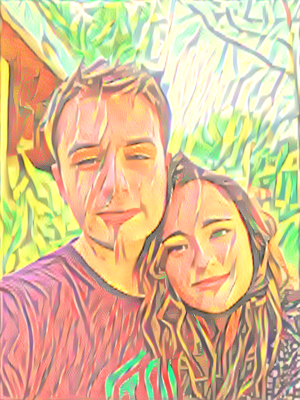

Epoch 1480


In [16]:
ma_photo_1500 = Image.open('/content/epoch1480.png').resize((300,400))
display(ma_photo_1500)
print('Epoch 1480')

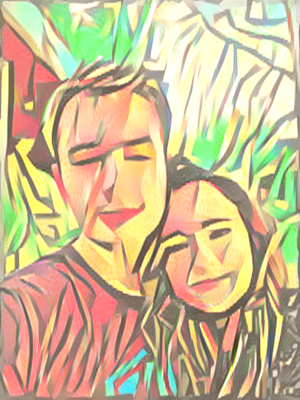

Epoch 10 000


In [17]:
ma_photo_10000 = Image.open('/content/epoch10k.png').resize((300,400))
display(ma_photo_10000)
print("Epoch 10 000")